# FittingFactor.ipynb

### Compute fitting factors between GR and beyond-GR waveforms

Maria Okounkova (mokounkova@flatironinstitute.org)

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.optimize import minimize_scalar
from ipynb.fs.full.Auxiliary import GetPeakTime, ComputeInnerProduct, ComputeOverlap, ComputeMultiDetectorInnerProduct, ComputeMultiDetectorOverlap
from pycbc.filter.matchedfilter import overlap
from pycbc.waveform import td_approximants, get_td_waveform
from pycbc.detector import Detector
from math import pi

/home/maria.okounkova/.local/lib/python3.6/site-packages/gwtools/rotations.py:63: UserWarning: Could not import GWFrames, needed for rotations module
  _warnings.warn("Could not import GWFrames, needed for rotations module")
/home/maria.okounkova/.local/lib/python3.6/site-packages/gwtools/__init__.py:11: UserWarning: Could not import rotations, decompositions, or fitfuncs. These are not needed by GWSurrogate.
  _warnings.warn("Could not import rotations, decompositions, or fitfuncs. These are not needed by GWSurrogate.")


setting __package__ to gwsurrogate.new so relative imports work
__name__ = gwsurrogate.new.spline_evaluation
__package__= gwsurrogate.new
setting __package__ to gwsurrogate.new so relative imports work
setting __package__ to gwsurrogate.new so relative imports work


In [2]:
print(td_approximants())

['TaylorT1', 'TaylorT2', 'TaylorT3', 'SpinTaylorT1', 'SpinTaylorT4', 'SpinTaylorT5', 'PhenSpinTaylor', 'PhenSpinTaylorRD', 'EOBNRv2', 'EOBNRv2HM', 'TEOBResum_ROM', 'SEOBNRv1', 'SEOBNRv2', 'SEOBNRv2_opt', 'SEOBNRv3', 'SEOBNRv3_pert', 'SEOBNRv3_opt', 'SEOBNRv3_opt_rk4', 'SEOBNRv4', 'SEOBNRv4_opt', 'SEOBNRv4P', 'SEOBNRv4PHM', 'SEOBNRv2T', 'SEOBNRv4T', 'SEOBNRv4_ROM_NRTidalv2', 'SEOBNRv4_ROM_NRTidalv2_NSBH', 'HGimri', 'IMRPhenomA', 'IMRPhenomB', 'IMRPhenomC', 'IMRPhenomD', 'IMRPhenomD_NRTidalv2', 'IMRPhenomNSBH', 'IMRPhenomHM', 'IMRPhenomPv2', 'IMRPhenomPv2_NRTidal', 'IMRPhenomPv2_NRTidalv2', 'TaylorEt', 'TaylorT4', 'EccentricTD', 'SpinDominatedWf', 'NR_hdf5', 'NRSur7dq2', 'NRSur7dq4', 'SEOBNRv4HM', 'NRHybSur3dq8', 'IMRPhenomXAS', 'IMRPhenomXHM', 'IMRPhenomPv3', 'IMRPhenomPv3HM', 'TaylorF2', 'SEOBNRv1_ROM_EffectiveSpin', 'SEOBNRv1_ROM_DoubleSpin', 'SEOBNRv2_ROM_EffectiveSpin', 'SEOBNRv2_ROM_DoubleSpin', 'EOBNRv2_ROM', 'EOBNRv2HM_ROM', 'SEOBNRv2_ROM_DoubleSpin_HI', 'SEOBNRv4_ROM', 'IMRPheno

In [8]:
## Actual parameter values
params = {'dt' : 1/2048, 't_gps' : 1126259462.0, 'peak_time_in_segment' : 8.0, 'segment_length' : 16.0, \
               'dist_mpc' : 601.0372365294345, 'mass' : 68.0, 'q' : 1.2212532137858916, \
               "chirp_mass": 29.422167356249002,  "m_1": 37.38665093292035, "m_2": 30.61334906707965, \
               'a_1' : [0, 0, 0.329892752405], 'a_2' : [0, 0, -0.439940981499], \
               'f_low' : 25, 'theta' : pi, 'phi' : 0, \
               'ra' : 1.952318922, 'dec' : -1.26967171703, 'pol' : 0.824043851821, 'f_ref' : 30.0}

In [9]:
det_h1 = Detector('H1')
det_l1 = Detector('L1')
det_v1 = Detector('V1')

In [10]:
def GenerateWaveform(phase, del_t):
    """ Given a phase and del_t (offset from t_gps), compute a waveform approximant """
    phase = 0.0
    hp, hc = get_td_waveform(approximant='IMRPhenomPv3HM',
                         mass1 = params["m_1"],
                         mass2 = params["m_2"],
                         spin1x = 0.0, spin1y = 0.0, spin1z=params["a_1"][2],
                         spin2x = 0.0, spin2y = 0.0, spin2z=params["a_2"][2],
                         delta_t = params["dt"],
                         f_ref = 30, 
                         f_lower = 30,
                         inclindation = params["theta"],
                         coa_phase = phase,
                         cos_phase = phase
                        )
    declination = params["dec"]
    right_ascension = params["ra"]
    polarization = params["pol"]
    hp.start_time += params["t_gps"] + del_t
    hc.start_time += params["t_gps"] + del_t 
    
    signal_h1 = det_h1.project_wave(hp, hc,  right_ascension, declination, polarization)
    #signal_l1 = det_l1.project_wave(hp, hc,  right_ascension, declination, polarization)
    #signal_v1 = det_v1.project_wave(hp, hc,  right_ascension, declination, polarization)
    
    return signal_h1

In [ ]:
signal = GenerateWaveform(0, 0)

ComputeInnerProduct(signal.sample_times, signal, signal.sample_times, signal, psd = True, f_low = 25, normalized = True)

Inner product start time:  1126259461.2285156  Inner product end time:  1126259462.131836


1.0

In [14]:
signal.sample_times[0]

1126259461.2285156

### Function to generate phenom waveforms

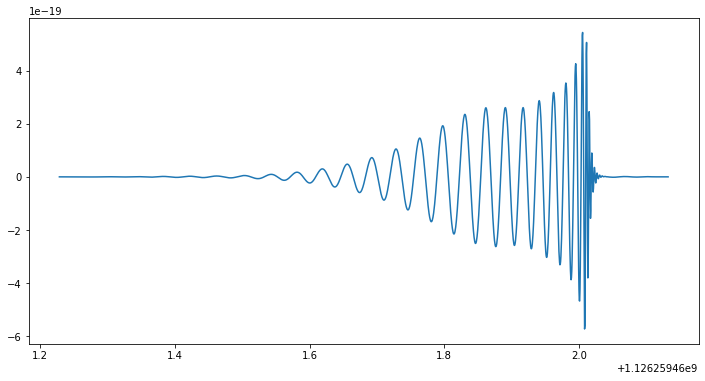

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(signal.sample_times, signal)
plt.show()

### Overlap computation

In [ ]:
## Given two waveforms in a single interferometer, compute the mismatch between them

### Parameter Search

In [ ]:
# D = 15 ## See Frame.prior bilby file
# SNR_detection = np.sqrt(D / (2 * mismatches))
# plt.figure(figsize=(8, 6))
# plt.plot(ells, SNR_detection, '-o')
# plt.yscale('log')
# #plt.xscale('log')
# plt.show()